# 📚 Phishing Email Detection using BERT - Project Notebook

## 📌 Table of Contents

1. [Project Overview](#project-overview)
2. [Environment Setup](#environment-setup)
3. [Data Loading and Sampling](#data-loading-and-sampling)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
    - [Label Distribution](#label-distribution)
    - [Text Length Analysis](#text-length-analysis)
    - [Special Characters & URL Analysis](#special-characters--url-analysis)
    - [Top Words in Phishing Emails](#top-words-in-phishing-emails)
5. [Data Preprocessing](#data-preprocessing)
    - [Lowercasing](#lowercasing)
    - [Stopwords Removal (Optional)](#stopwords-removal-optional)
6. [Train-Validation-Test Split (70/10/20)](#train-validation-test-split-701020)
7. [Tokenization using BERT Tokenizer](#tokenization-using-bert-tokenizer)
8. [Dataset Preparation for PyTorch](#dataset-preparation-for-pytorch)
9. [Model Setup with BERT](#model-setup-with-bert)
10. [Define Training Arguments](#define-training-arguments)
11. [Trainer Setup and Metrics](#trainer-setup-and-metrics)
12. [Model Training](#model-training)
13. [Evaluate on Validation Set](#evaluate-on-validation-set)
14. [Evaluate on Test Set](#evaluate-on-test-set)
    - [Accuracy, Precision, Recall, F1-Score](#accuracy-precision-recall-f1-score)
    - [Confusion Matrix](#confusion-matrix)
15. [Plot Metrics (Accuracy/Loss vs Epoch)](#plot-metrics-accuracyloss-vs-epoch)
16. [Saving the Model and Tokenizer](#saving-the-model-and-tokenizer)
17
18. [Load Trained Model for Inference](#load-trained-model-for-inference)
19. [Next Steps and Improvements](#next-steps-and-improvements)


## Project overview
With the rapid rise of AI-generated content, phishing emails have become more sophisticated and harder to detect through traditional methods. Attackers now craft deceptive messages that closely mimic legitimate communication, putting individuals and organizations at risk of data theft, financial fraud, and identity compromise. This project aims to address the growing threat by developing an intelligent phishing email detection system using BERT, a powerful transformer-based language model. By analyzing the textual content of emails, our model learns to distinguish between phishing and legitimate messages with high accuracy, helping to automate and enhance email security on a large scale.

In [1]:
import pandas as pd
import re
import torch

#libraries for data explore
import seaborn as sns
import matplotlib.pyplot as plt

#libraries for Model training and evaluation
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


In [25]:
# Example: Load a CSV dataset
df = pd.read_csv("phishing_email.csv")


df.shape

(82797, 2)

In [27]:
# Randomly sample 15,000 rows from the full dataset
df = df.sample(n=15000, random_state=42).reset_index(drop=True)

print(df.head())

                                                text  label
0  budget review ii hi louise ok us coming see th...    0.0
1  blake stevenson damongoalmackbrinksternet read...    1.0
2  home l oa n revised acceptpk good day glad inf...    1.0
3  timonecomcastnet tim peters greg ward case hea...    0.0
4  updating profile information gis system global...    0.0


## Preprocess the Data

- **Remove null**
- **Lowercasing** : BERT handles case, but lowercase helps traditional models


# Preprocessing Steps Not Applied (with Justifications)

- **Remove URLs** : URLs are strong indicators of phishing, so we keep them as features.
- **Remove special characters** : Symbols like @, !, $, etc., are commonly used in phishing tactics and should be retained.
- **Remove punctuation** : Punctuation may be part of deceptive formatting or URLs, so we do not remove it.
- **Remove numbers** : Numbers (like fake invoice IDs or OTPs) may signal phishing intent, so we preserve them.
- **Remove stopwords** : Common words may carry phishing signals in certain contexts, so we keep them for now.
- **Remove capital letters** : Capitalization (e.g., “URGENT”) often indicates phishing, so we retain letter casing.
- **Stemming or Lemmatization** : We keep words in their original form to preserve possible phishing-related phrasing.
- **Remove HTML tags** : Some phishing emails use HTML tricks; we want to analyze them if present.
- **Spelling correction** : Typos and misspellings may be deliberate in phishing emails, so we avoid correcting them.



In [28]:
# Remove nulls
df.dropna(inplace=True)

df['label'] = df['label'].astype(int)

# Lowercasing only
def clean_text(text):
    return text.lower()

df['text'] = df['text'].apply(clean_text)



In [29]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14949 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    14949 non-null  object
 1   label   14949 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 350.4+ KB
None


In [30]:
df.shape

(14949, 2)

In [31]:
df.tail()

,text,label
14995,matemtica financeira matemtica financeira em c...,1
14996,accounting list per request attached find acco...,0
14997,avistar users allocated charges several querie...,0
14998,cnn alerts tobinklonten3pcompanyit cnn alerts ...,1
14999,daugther waits worked late nights coming home ...,1


# Explore the dataset

#### Plot Class Distribution

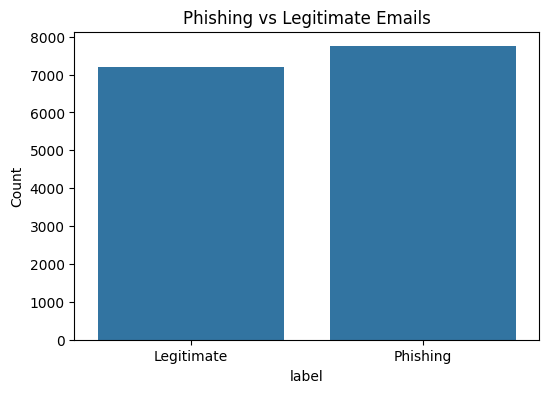

In [32]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label') # counts the number of occurrences of each unique value in a column
plt.title('Phishing vs Legitimate Emails')
plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.ylabel('Count')
plt.show()


#### Email/Text special character Length Distribution by Class
This graph is a boxplot comparing the number of special characters used in legitimate vs phishing emails.

Special characters: ! @ # $ % ^ & * ( ) _ + = { } [ ] : ; " ' < > / ? , . ~ etc.


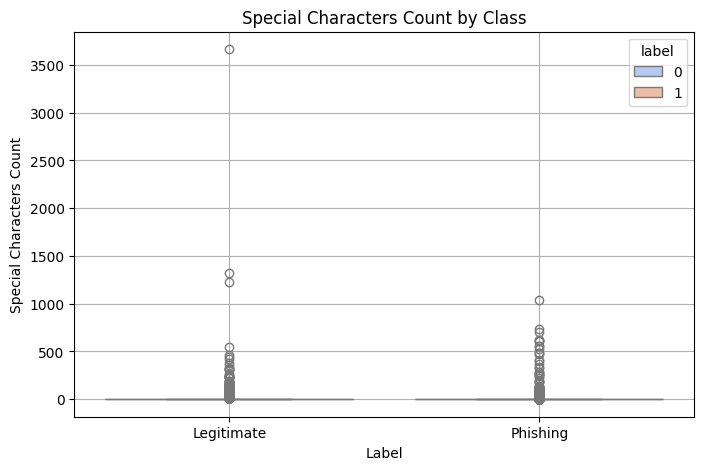

In [33]:
df['special_chars'] = df['text'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

plt.figure(figsize=(8,5))
sns.boxplot(x='label', y='special_chars', data=df, hue='label', palette='coolwarm', dodge=False)

plt.xticks([0, 1], ['Legitimate', 'Phishing'])
plt.title('Special Characters Count by Class')
plt.xlabel('Label')
plt.ylabel('Special Characters Count')
plt.grid(True)
plt.show()


#### Most Common Words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


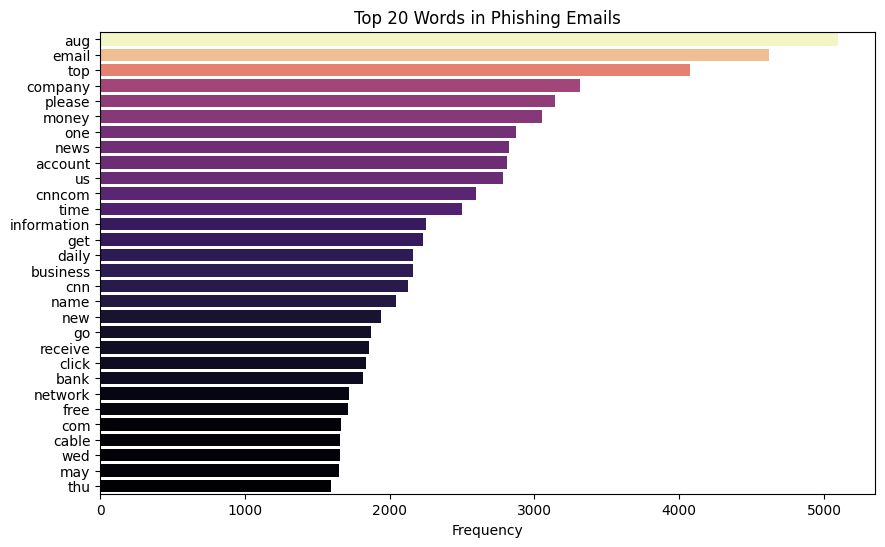

In [34]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


stop_words = set(stopwords.words('english'))  #e.g., "the", "is", "and"

# Combine all phishing emails: Joins all texts into one string → converts to lowercase → splits into words
phishing_words = ' '.join(df[df['label']==1]['text']).lower().split() #Selects only phishing emails (where label == 1)

filtered_words = [word for word in phishing_words if word.isalpha() and word not in stop_words] #Alphabetic words (removes numbers, punctuation)

word_freq = Counter(filtered_words).most_common(30)

# Barplot of top words
words, counts = zip(*word_freq)  #Unpacks the 20 most common word–count pairs into two separate lists: words and counts
plt.figure(figsize=(10,6))
sns.barplot(x=list(counts), y=list(words),hue =list(counts), palette='magma',legend=False)
plt.title('Top 20 Words in Phishing Emails')
plt.xlabel('Frequency')
plt.show()



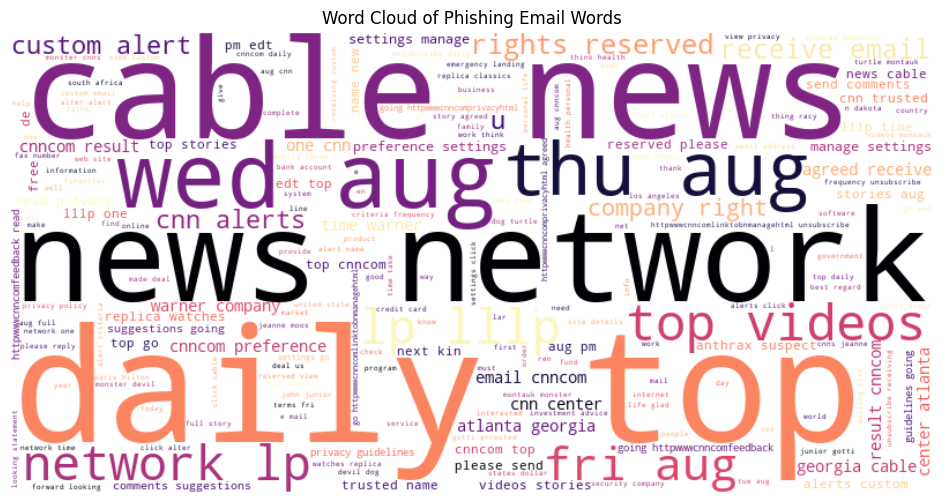

In [35]:
from wordcloud import WordCloud

# Join all filtered phishing words into a single string
wordcloud_text = ' '.join(filtered_words)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(wordcloud_text)

# Display the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Phishing Email Words')
plt.show()


 ### Split the Dataset in training , validation and test

In [36]:
from sklearn.model_selection import train_test_split

# 1. First, split out 20% test data

train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label'])

# 2. Then split remaining 80% into 70% train and 10% val

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels,
    test_size=0.125,  # 10% of total = 12.5% of the remaining 80%
    random_state=42, stratify=train_val_labels
)


#### Tokenization using BERT Tokenizer

These encodings are the tokenized versions of your input texts, structured in a way that BERT can understand

In [37]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the datasets
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)


In [44]:
print(train_encodings['input_ids'][0])          # View input IDs of the first text
print(train_encodings['attention_mask'][0]) 

[101, 4070, 3438, 21619, 20958, 2692, 1044, 4646, 3653, 4844, 22294, 2290, 25416, 3981, 5897, 2832, 3653, 4844, 6165, 3225, 1017, 2423, 4964, 3531, 2224, 5851, 2609, 6039, 4646, 4067, 4895, 2862, 8299, 7479, 2062, 2102, 20420, 3351, 5658, 1060, 2358, 16129, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Convert to HuggingFace Dataset

A custom PyTorch dataset class for handling tokenized email text data and labels.

- **Inherits**: `torch.utils.data.Dataset`
- **Purpose**: Feeds input to Hugging Face `Trainer` in a structured format.

#### Methods:
- `__init__(self, encodings, labels)`
  - Stores tokenized input data (`encodings`) and labels.
- `__getitem__(self, idx)`
  - Returns the input tensors and label for a specific index.
  - Example output:
    ```python
    {
      'input_ids': tensor(...),
      'attention_mask': tensor(...),
      'labels': tensor(...)
    }
    ```
- `__len__(self)`
  - Returns the total number of samples.
 
    
 
#### Data input format for bert
- input_ids: Token IDs representing the input text.

- attention_mask: Binary mask to distinguish real tokens (1) from padding (0).

- labels: True class values used for supervised learning.

- [CLS]: Special token added at the start of input for classification tasks.

- [SEP]: Separator token marking the end of a sentence or segment.



In [38]:
class EmailDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmailDataset(train_encodings, train_labels)
val_dataset = EmailDataset(val_encodings, val_labels)


#### Load Pretrained BERT for Classification

In [39]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Evaluation Metrics

In [40]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


#### Training Arguments

`TrainingArguments` is a configuration class that defines how your model should be trained. You pass it key training parameters such as:

- `output_dir`: Where to save model checkpoints.
- `learning_rate`: Controls how fast the model learns.
- `num_train_epochs`: Number of complete passes through the training data.
- `evaluation_strategy`: When to run validation (e.g., `"epoch"` means after every epoch).
- `per_device_train_batch_size`: Batch size per GPU/CPU device during training.
- `logging_dir`: Directory to store training logs.

It does **not** train the model — it only stores training settings that the `Trainer` will use.



In [50]:
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",       # Validates after each epoch
    save_strategy="epoch",             # Saves checkpoint after each epoch
    save_total_limit=2,                # Keep only last 2 checkpoints
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    optim="adamw_torch",
    logging_dir='./logs',
    logging_strategy="epoch",          # Log once per epoch
    load_best_model_at_end=True,       # Optional: load best val score model
    metric_for_best_model="f1",        # Based on compute_metrics
    greater_is_better=True             # Because higher F1 is better
)


#### Trainer




`Trainer` is the training engine provided by Hugging Face. It handles the full model training lifecycle. Specifically, it:

- Loads and trains your model.
- Handles batching, shuffling, and tokenization.
- Trains the model using PyTorch under the hood.
- Evaluates the model on your `eval_dataset`.
- Uses the settings defined in `TrainingArguments`.
- Automatically supports training on GPU or TPU if available.

`Trainer` simplifies the process so you don’t need to manually write training loops, backpropagation, or optimizer logic.

In [51]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics
)

C:\Users\hp\AppData\Local\Temp\ipykernel_24232\3673888053.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### Train the BERT Model

The `trainer.train()` method is the command that **starts the training process** using the configuration and datasets you’ve defined with Hugging Face’s `Trainer` class.

It does the following:

- Loads the `train_dataset` and batches the data.
- Feeds each batch through the model.
- Computes the loss and performs backpropagation to update model weights.
- Evaluates the model on the `eval_dataset` if `evaluation_strategy` is set (e.g., `"epoch"`).
- Saves checkpoints if `save_strategy` is configured.
- Logs training metrics (loss, accuracy, etc.) if `logging_dir` is specified.

##### What It Uses Internally:
- Model defined in `Trainer(model=...)`
- Training configuration from `TrainingArguments`
- Tokenizer and data collator for handling padding and batching
- Evaluation function if `compute_metrics` is provided

##### Output:
After running `trainer.train()`, the model will be:
- Trained on your training data
- Optionally validated each epoch
- Saved to the directory specified in `output_dir`


In [52]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## Plot Accuracy and Loss vs Epoch

In [ ]:
import matplotlib.pyplot as plt

# Extract logs
log_history = trainer.state.log_history

# Gather data
train_loss = [entry['loss'] for entry in log_history if 'loss' in entry]
eval_loss = [entry['eval_loss'] for entry in log_history if 'eval_loss' in entry]
eval_acc  = [entry['eval_accuracy'] for entry in log_history if 'eval_accuracy' in entry]
epochs = list(range(1, len(eval_loss)+1))

# Plot loss
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, eval_acc, marker='o', color='green', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()


## Save the Final Model & Tokenizer

In [ ]:
# Save model and tokenizer
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer
model = BertForSequenceClassification.from_pretrained("./final_model")
tokenizer = BertTokenizer.from_pretrained("./final_model")


### Test the model

##### Tokenize test data

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

#### Convert to PyTorch Dataset

In [ ]:
test_dataset = EmailDataset(test_encodings, test_labels)

#### Evaluate Model on Test Set

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Run predictions on the test set
test_results = trainer.predict(test_dataset)

# Extract predicted class labels
y_pred = test_results.predictions.argmax(axis=1)
y_true = test_labels  # Make sure test_labels is a list of integers

# Print all core metrics
print("Final Test Evaluation Metrics:\n")
print("Accuracy       :", accuracy_score(y_true, y_pred))
print("Precision      :", precision_score(y_true, y_pred))
print("Recall         :", recall_score(y_true, y_pred))
print("F1 Score       :", f1_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Legitimate", "Phishing"]))



In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

y_pred = test_results.predictions.argmax(axis=1)
print(classification_report(test_labels, y_pred, target_names=["Legitimate", "Phishing"]))
